In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import cv2

In [3]:
train_path="image_exercise/data/Skin_Cancer_Images/Train"
test_path="image_exercise/data/Skin_Cancer_Images/Test"

In [4]:
# Let us use ImageDataGenerator from Keras to create Train and Validation i.e. test generator objects
# As required, image data wil be rescaled to values between 0 to 1 and target image size is 180 X 180 Pixels.
# we will keep changing train_generator down the line , but test_generator object called val_generator will remain unchanged
# since we are not going to change test images, but play with the training images.

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

train_datagen = ImageDataGenerator(
    rescale=1./255,
)
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(180,180), 
    color_mode='rgb', 
    batch_size=batch_size, 
    class_mode='categorical', 
    shuffle=True)

# Create an instance of the ImageDataGenerator class, rescaling value between 0 and 1 i.e. normalisation
test_datagen = ImageDataGenerator(rescale=1./255)


val_generator = test_datagen.flow_from_directory(
        test_path,
        target_size= (180, 180),
        color_mode='rgb', 
        batch_size = batch_size,
        class_mode = 'categorical',
        
)

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


In [5]:
NUM_CLASSES = max(train_generator.class_indices.values()) + 1
print(NUM_CLASSES)

# Get the class indices from the train generator
class_indices = train_generator.class_indices

# Reverse the class indices dictionary to get a dictionary mapping index values to class names
reverse_class_indices = {v: k for k, v in class_indices.items()}

print(reverse_class_indices)


9
{0: 'actinic keratosis', 1: 'basal cell carcinoma', 2: 'dermatofibroma', 3: 'melanoma', 4: 'nevus', 5: 'pigmented benign keratosis', 6: 'seborrheic keratosis', 7: 'squamous cell carcinoma', 8: 'vascular lesion'}


['/Users/dhananjayjoshi/mlai/image_exercise/data/Skin_Cancer_Images/Train/actinic keratosis/ISIC_0030655.jpg']


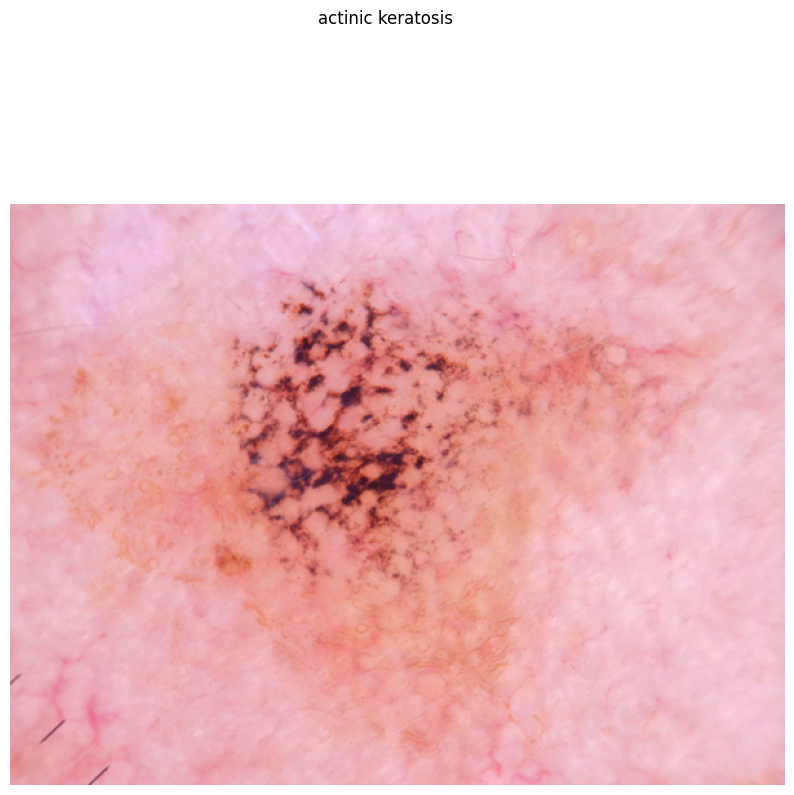

['/Users/dhananjayjoshi/mlai/image_exercise/data/Skin_Cancer_Images/Train/basal cell carcinoma/ISIC_0028106.jpg']


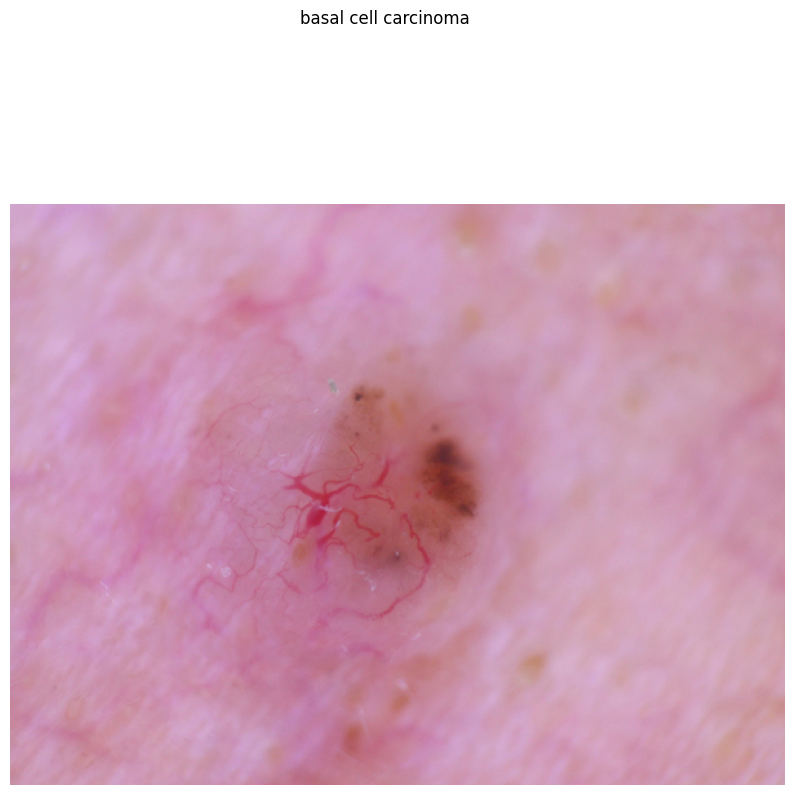

['/Users/dhananjayjoshi/mlai/image_exercise/data/Skin_Cancer_Images/Train/dermatofibroma/ISIC_0025911.jpg']


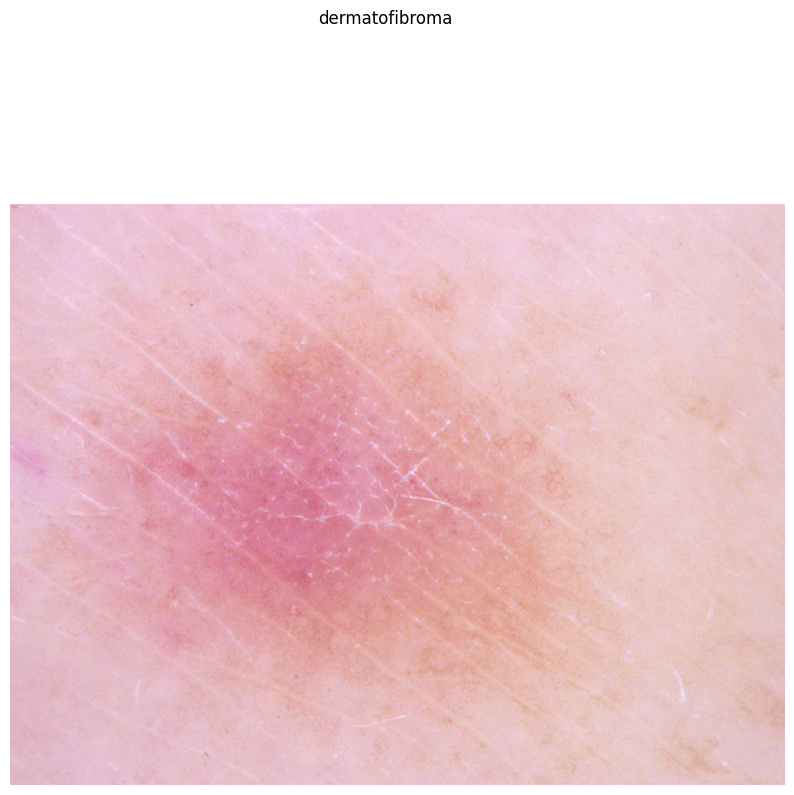

['/Users/dhananjayjoshi/mlai/image_exercise/data/Skin_Cancer_Images/Train/melanoma/ISIC_0011158.jpg']


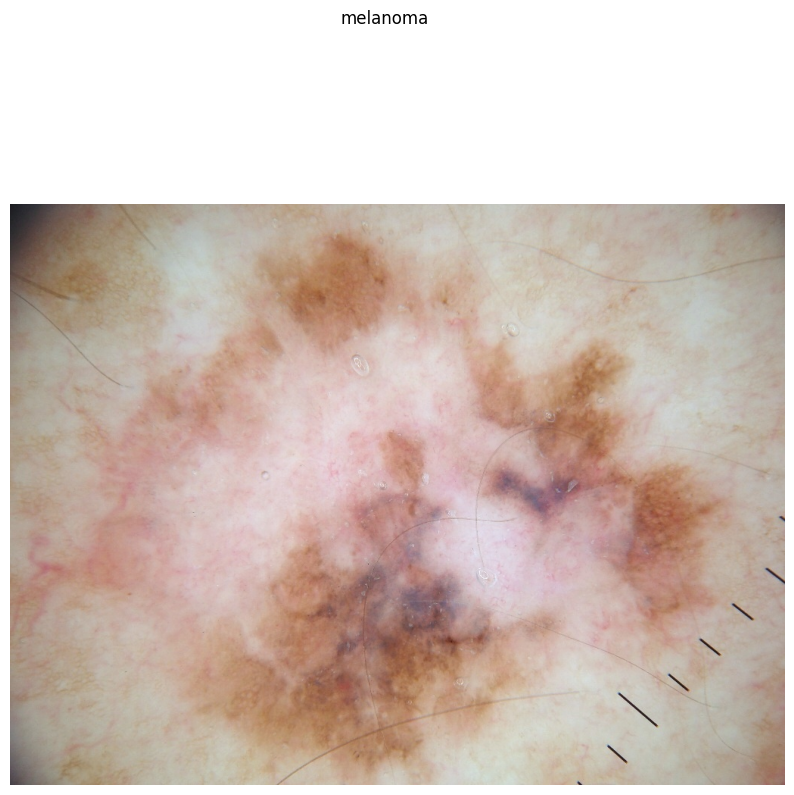

['/Users/dhananjayjoshi/mlai/image_exercise/data/Skin_Cancer_Images/Train/nevus/ISIC_0000345.jpg']


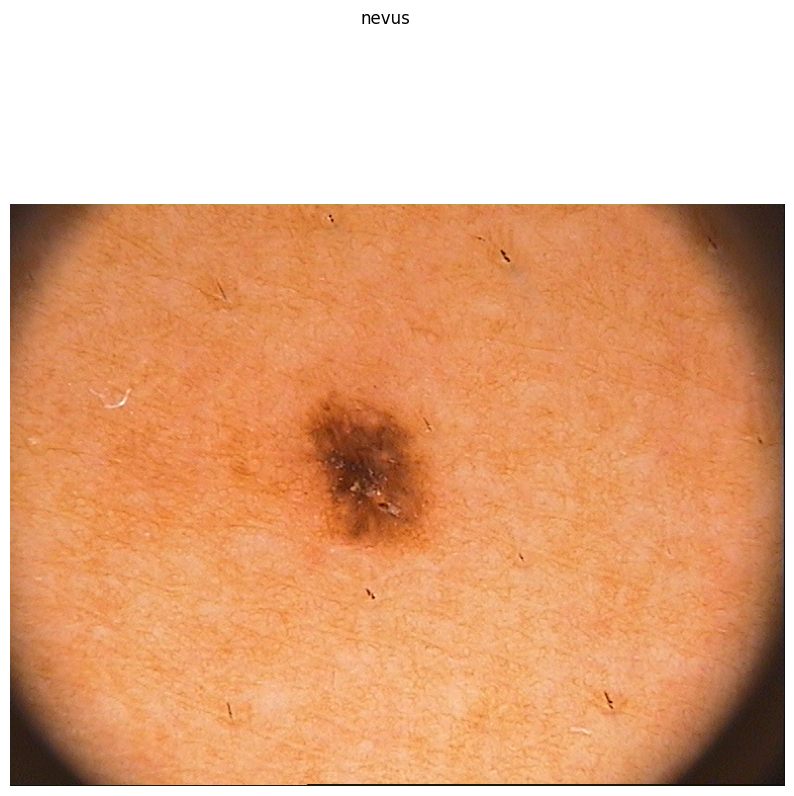

['/Users/dhananjayjoshi/mlai/image_exercise/data/Skin_Cancer_Images/Train/pigmented benign keratosis/ISIC_0025699.jpg']


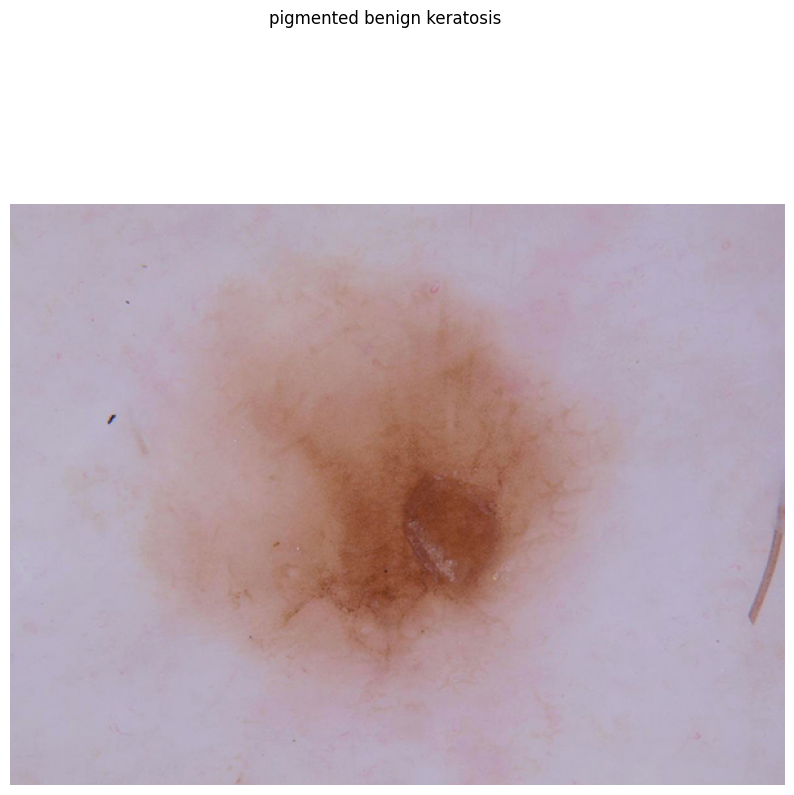

['/Users/dhananjayjoshi/mlai/image_exercise/data/Skin_Cancer_Images/Train/seborrheic keratosis/ISIC_0011040.jpg']


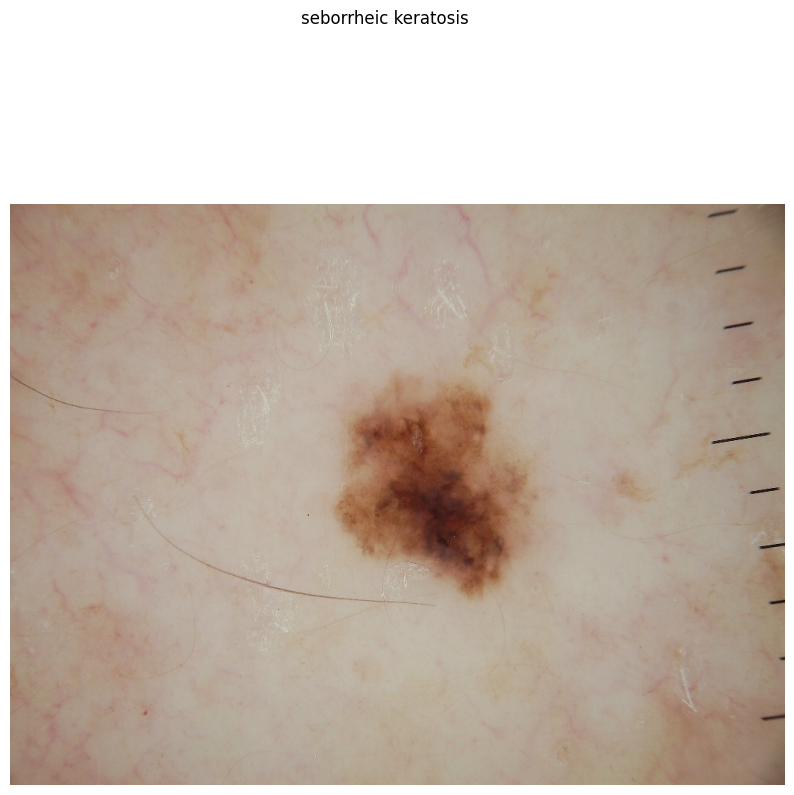

['/Users/dhananjayjoshi/mlai/image_exercise/data/Skin_Cancer_Images/Train/squamous cell carcinoma/ISIC_0030245.jpg']


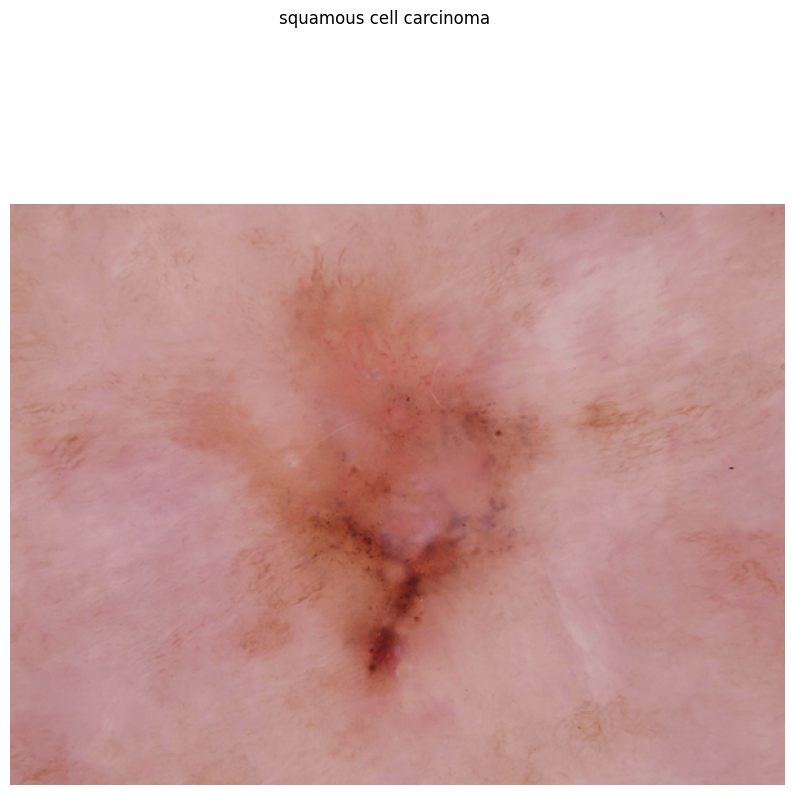

['/Users/dhananjayjoshi/mlai/image_exercise/data/Skin_Cancer_Images/Train/vascular lesion/ISIC_0028146.jpg']


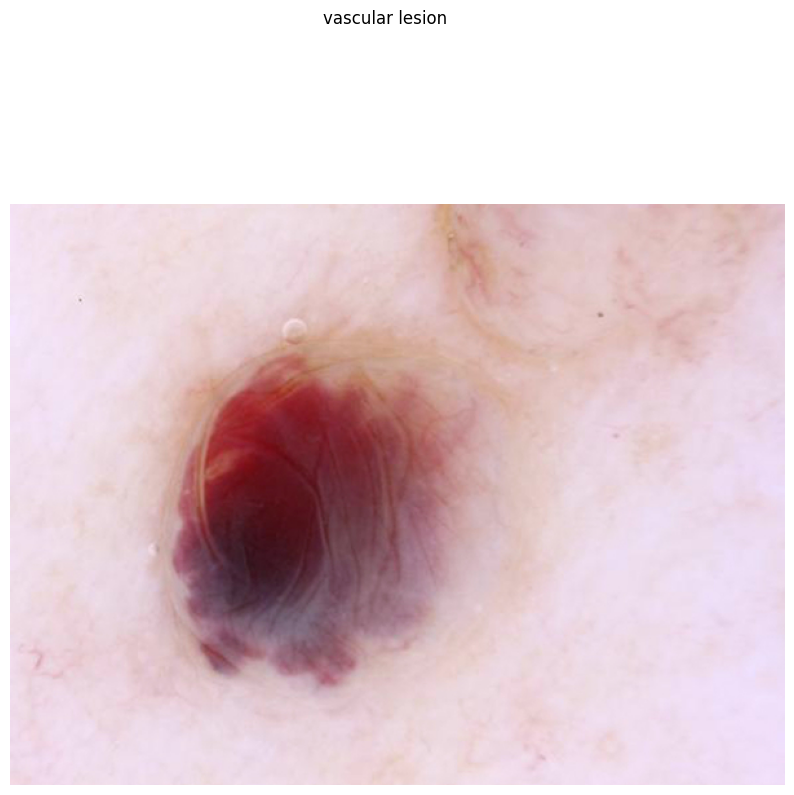

In [11]:
# We can visualise some of the images.
# Sample inspection of images , we choose 1 random sample from each class
samples_per_class = 1


for i in range(NUM_CLASSES):
    # Get the filenames and class labels for the images in the current class
    class_name = reverse_class_indices[i]
    class_dir = os.path.join(train_path, class_name)
    filenames = os.listdir(class_dir)
    filenames = [os.path.join(class_dir, f) for f in filenames]
    labels = [i] * len(filenames)
    
    # Select a random subset of images from the current class
    indices = np.random.choice(len(filenames), samples_per_class, replace=False)
    subset_filenames = [filenames[j] for j in indices]
    print(subset_filenames)

    # Plot the selected images in a row
    fig, axs = plt.subplots(1, 1,  figsize=(10, 10))
    fig.suptitle(class_name)
    img = plt.imread(subset_filenames[0])
    axs.imshow(img)
    axs.axis('off')
    plt.show()


In [49]:
# Base model with CNN and Pooling layers, without any augmentation. 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam

def create_model_base():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(180, 180, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=NUM_CLASSES, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint
epochs = 20

# let us create checkpoint so that weights are saved after every epoch
checkpoint_filepath = 'ccn_checkpoint_5.h5'
checkpoint = ModelCheckpoint(checkpoint_filepath, save_weights_only=True)

# Train the model using the generated batches of data
step_size_train = train_generator.n // train_generator.batch_size
step_size_test = val_generator.n // val_generator.batch_size

#model.load_weights('drive/My Drive/Skin_Cancer_Images/ccn_checkpoint_5.h5')
model = create_model_base()
model.fit(
        train_generator,       
        steps_per_epoch=step_size_train,                                                                 
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=step_size_test,
        callbacks=[checkpoint])

model.save("ccn_model_0.h5")



Epoch 1/20


2023-04-18 17:50:52.092189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


69/69 [==============================] - ETA: 0s - loss: 2.0140 - accuracy: 0.2515

2023-04-18 17:51:50.989877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


69/69 [==============================] - 66s 944ms/step - loss: 2.0140 - accuracy: 0.2515 - val_loss: 2.1482 - val_accuracy: 0.2604
Epoch 2/20
69/69 [==============================] - 63s 912ms/step - loss: 1.5941 - accuracy: 0.4395 - val_loss: 2.7121 - val_accuracy: 0.3125
Epoch 3/20
69/69 [==============================] - 60s 865ms/step - loss: 1.4337 - accuracy: 0.5093 - val_loss: 2.6696 - val_accuracy: 0.3646
Epoch 4/20
69/69 [==============================] - 60s 870ms/step - loss: 1.3820 - accuracy: 0.5084 - val_loss: 2.1603 - val_accuracy: 0.3750
Epoch 5/20
69/69 [==============================] - 62s 896ms/step - loss: 1.2889 - accuracy: 0.5555 - val_loss: 2.7231 - val_accuracy: 0.3542
Epoch 6/20
69/69 [==============================] - 59s 853ms/step - loss: 1.2276 - accuracy: 0.5605 - val_loss: 2.7007 - val_accuracy: 0.4167
Epoch 7/20
69/69 [==============================] - 65s 943ms/step - loss: 1.1834 - accuracy: 0.5705 - val_loss: 2.3198 - val_accuracy: 0.3229
Epoch 8/20

# Base model indicates high training accuracy touching 81%. However, validation i.e. test accuracy is half way mark i.e. 40%. So model is overfit and unable to do we ll on unseen data. 

# Let us try different data augmentations - a) rotation b) zoom c) Horizontal and vertifal shifts etc.

In [17]:
# Let us try one data augmentation strategy at a time. this is zoom change
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam

train_datagen = ImageDataGenerator(
    zoom_range=[0.5,1.0],
    rescale=1./255,
)
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(180,180), 
    color_mode='rgb', 
    batch_size=batch_size, 
    class_mode='categorical', 
    shuffle=True)

model = create_model_base()

epochs = 20

# Train the model using the generated batches of data
step_size_train = train_generator.n // train_generator.batch_size
step_size_test = val_generator.n // val_generator.batch_size

#model.load_weights('drive/My Drive/Skin_Cancer_Images/ccn_checkpoint_5.h5')

model.fit(
        train_generator,       
        steps_per_epoch=step_size_train,                                                                 
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=step_size_test,
        callbacks=[checkpoint])

model.save("ccn_model_1.h5")



Found 2239 images belonging to 9 classes.
Epoch 1/20


2023-04-18 18:16:35.016729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


69/69 [==============================] - ETA: 0s - loss: 1.9683 - accuracy: 0.2728

2023-04-18 18:17:38.134859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


69/69 [==============================] - 69s 995ms/step - loss: 1.9683 - accuracy: 0.2728 - val_loss: 2.2296 - val_accuracy: 0.2396
Epoch 2/20
69/69 [==============================] - 70s 1s/step - loss: 1.6170 - accuracy: 0.4164 - val_loss: 2.2732 - val_accuracy: 0.3021
Epoch 3/20
69/69 [==============================] - 84s 1s/step - loss: 1.4439 - accuracy: 0.4835 - val_loss: 2.4952 - val_accuracy: 0.2708
Epoch 4/20
69/69 [==============================] - 68s 978ms/step - loss: 1.3765 - accuracy: 0.5034 - val_loss: 2.0226 - val_accuracy: 0.2396
Epoch 5/20
69/69 [==============================] - 69s 1s/step - loss: 1.4361 - accuracy: 0.4930 - val_loss: 2.5930 - val_accuracy: 0.2604
Epoch 6/20
69/69 [==============================] - 73s 1s/step - loss: 1.2987 - accuracy: 0.5347 - val_loss: 2.2696 - val_accuracy: 0.3021
Epoch 7/20
69/69 [==============================] - 69s 999ms/step - loss: 1.2848 - accuracy: 0.5383 - val_loss: 2.2308 - val_accuracy: 0.3125
Epoch 8/20
69/69 [====

In [18]:
# # Let us try another  data augmentation strategy - horizontal/vertical flips
# and rotation changes.
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=50,
    rescale=1./255,
)
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(180,180), 
    color_mode='rgb', 
    batch_size=batch_size, 
    class_mode='categorical', 
    shuffle=True)


model = create_model_base()
epochs = 20

# Train the model using the generated batches of data
step_size_train = train_generator.n // train_generator.batch_size
step_size_test = val_generator.n // val_generator.batch_size



#model.load_weights('drive/My Drive/Skin_Cancer_Images/ccn_checkpoint_5.h5')

model.fit(
        train_generator,       
        steps_per_epoch=step_size_train,                                                                 
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=step_size_test,
        callbacks=[checkpoint])

model.save("ccn_model_2.h5")


Found 2239 images belonging to 9 classes.


2023-04-18 19:23:36.750269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 1/20
69/69 [==============================] - ETA: 0s - loss: 2.0921 - accuracy: 0.2324

2023-04-18 19:25:30.604861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


69/69 [==============================] - 120s 2s/step - loss: 2.0921 - accuracy: 0.2324 - val_loss: 2.2317 - val_accuracy: 0.1354
Epoch 2/20
69/69 [==============================] - 88s 1s/step - loss: 1.6915 - accuracy: 0.3919 - val_loss: 2.1559 - val_accuracy: 0.3229
Epoch 3/20
69/69 [==============================] - 83s 1s/step - loss: 1.4946 - accuracy: 0.4744 - val_loss: 2.2831 - val_accuracy: 0.2396
Epoch 4/20
69/69 [==============================] - 79s 1s/step - loss: 1.4317 - accuracy: 0.4952 - val_loss: 2.0869 - val_accuracy: 0.2917
Epoch 5/20
69/69 [==============================] - 108s 2s/step - loss: 1.3484 - accuracy: 0.5274 - val_loss: 2.1268 - val_accuracy: 0.3125
Epoch 6/20
69/69 [==============================] - 207s 3s/step - loss: 1.3327 - accuracy: 0.5297 - val_loss: 2.2078 - val_accuracy: 0.3021
Epoch 7/20
69/69 [==============================] - 84s 1s/step - loss: 1.2873 - accuracy: 0.5433 - val_loss: 2.0251 - val_accuracy: 0.3542
Epoch 8/20
69/69 [==========

In [19]:
# Let us try multiple data augmentation options together i.e. shift , flips, rotations, brightness and zoom changes
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

train_datagen = ImageDataGenerator(width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             rotation_range=50,
                             brightness_range=[0.15,2.0],
                             zoom_range=[5,0.5], 
                             rescale=1./255)


batch_size = 32

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(180,180), 
    color_mode='rgb', 
    batch_size=batch_size, 
    class_mode='categorical', 
    shuffle=True)


from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam

model = create_model_base()
epochs = 20

# Train the model using the generated batches of data
step_size_train = train_generator.n // train_generator.batch_size
step_size_test = val_generator.n // val_generator.batch_size

#model.load_weights('drive/My Drive/Skin_Cancer_Images/ccn_checkpoint_5.h5')

model.fit(
        train_generator,       
        steps_per_epoch=step_size_train,                                                                 
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=step_size_test,
        callbacks=[checkpoint])

model.save("ccn_model_3.h5")

Found 2239 images belonging to 9 classes.
Epoch 1/20


2023-04-18 19:58:04.966328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


69/69 [==============================] - ETA: 0s - loss: 2.1079 - accuracy: 0.2130

2023-04-18 19:59:23.795776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


69/69 [==============================] - 86s 1s/step - loss: 2.1079 - accuracy: 0.2130 - val_loss: 2.3859 - val_accuracy: 0.2188
Epoch 2/20
69/69 [==============================] - 84s 1s/step - loss: 1.8908 - accuracy: 0.3176 - val_loss: 2.6166 - val_accuracy: 0.2396
Epoch 3/20
69/69 [==============================] - 83s 1s/step - loss: 1.7577 - accuracy: 0.3706 - val_loss: 2.3449 - val_accuracy: 0.2396
Epoch 4/20
69/69 [==============================] - 78s 1s/step - loss: 1.6551 - accuracy: 0.4010 - val_loss: 2.5491 - val_accuracy: 0.2396
Epoch 5/20
69/69 [==============================] - 83s 1s/step - loss: 1.6546 - accuracy: 0.4159 - val_loss: 2.1558 - val_accuracy: 0.3229
Epoch 6/20
69/69 [==============================] - 83s 1s/step - loss: 1.6136 - accuracy: 0.4241 - val_loss: 2.7555 - val_accuracy: 0.2188
Epoch 7/20
69/69 [==============================] - 82s 1s/step - loss: 1.5918 - accuracy: 0.4318 - val_loss: 2.2647 - val_accuracy: 0.3021
Epoch 8/20
69/69 [=============

In [21]:
# Let us try different data augmentation options together i.e. rotation, brightness change and Zoom
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

train_datagen = ImageDataGenerator(
                             rotation_range=50,
                             brightness_range=[0.15,2.0],
                             zoom_range=[5,0.5], 
                             rescale=1./255)


batch_size = 32

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(180,180), 
    color_mode='rgb', 
    batch_size=batch_size, 
    class_mode='categorical', 
    shuffle=True)

model = create_model_base()
epochs = 20

# Train the model using the generated batches of data
step_size_train = train_generator.n // train_generator.batch_size
step_size_test = val_generator.n // val_generator.batch_size

#model.load_weights('drive/My Drive/Skin_Cancer_Images/ccn_checkpoint_5.h5')

model.fit(
        train_generator,       
        steps_per_epoch=step_size_train,                                                                 
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=step_size_test,
        callbacks=[checkpoint])

model.save("ccn_model_4.h5")

Found 2239 images belonging to 9 classes.
Epoch 1/20


2023-04-18 20:56:48.612780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


69/69 [==============================] - ETA: 0s - loss: 2.0927 - accuracy: 0.2211

2023-04-18 20:58:56.803380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


69/69 [==============================] - 142s 2s/step - loss: 2.0927 - accuracy: 0.2211 - val_loss: 2.2233 - val_accuracy: 0.1354
Epoch 2/20
69/69 [==============================] - 148s 2s/step - loss: 1.9742 - accuracy: 0.2574 - val_loss: 2.2401 - val_accuracy: 0.2500
Epoch 3/20
69/69 [==============================] - 150s 2s/step - loss: 1.8279 - accuracy: 0.3403 - val_loss: 2.3914 - val_accuracy: 0.2396
Epoch 4/20
69/69 [==============================] - 101s 1s/step - loss: 1.8399 - accuracy: 0.3235 - val_loss: 2.3007 - val_accuracy: 0.2604
Epoch 5/20
69/69 [==============================] - 277s 4s/step - loss: 1.7434 - accuracy: 0.3774 - val_loss: 2.3606 - val_accuracy: 0.2500
Epoch 6/20
69/69 [==============================] - 140s 2s/step - loss: 1.7212 - accuracy: 0.3788 - val_loss: 2.8037 - val_accuracy: 0.2812
Epoch 7/20
69/69 [==============================] - 124s 2s/step - loss: 1.6394 - accuracy: 0.4010 - val_loss: 2.3822 - val_accuracy: 0.2708
Epoch 8/20
69/69 [======

In [20]:
# Let us try with less number of layers i.e. reduce the number of layers without any augmentation .
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam


train_datagen = ImageDataGenerator(rescale=1./255)


batch_size = 32

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(180,180), 
    color_mode='rgb', 
    batch_size=batch_size, 
    class_mode='categorical', 
    shuffle=True)


model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(180, 180, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=len(class_indices), activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 20

checkpoint_filepath = 'ccn_checkpoint_5.h5'
checkpoint = ModelCheckpoint(checkpoint_filepath, save_weights_only=True)

# Train the model using the generated batches of data
step_size_train = train_generator.n // train_generator.batch_size
step_size_test = val_generator.n // val_generator.batch_size

#model.load_weights('drive/My Drive/Skin_Cancer_Images/ccn_checkpoint_5.h5')

model.fit(
        train_generator,       
        steps_per_epoch=step_size_train,                                                                 
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=step_size_test,
        callbacks=[checkpoint])

model.save("ccn_model_5.h5")


Found 2239 images belonging to 9 classes.
Epoch 1/20


2023-04-18 20:27:22.061628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


69/69 [==============================] - ETA: 0s - loss: 10.0584 - accuracy: 0.1686

2023-04-18 20:28:09.681465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


69/69 [==============================] - 54s 766ms/step - loss: 10.0584 - accuracy: 0.1686 - val_loss: 2.2000 - val_accuracy: 0.1562
Epoch 2/20
69/69 [==============================] - 53s 762ms/step - loss: 2.0230 - accuracy: 0.1971 - val_loss: 2.2502 - val_accuracy: 0.1354
Epoch 3/20
69/69 [==============================] - 51s 741ms/step - loss: 2.0194 - accuracy: 0.1957 - val_loss: 2.2636 - val_accuracy: 0.1458
Epoch 4/20
69/69 [==============================] - 52s 754ms/step - loss: 2.0187 - accuracy: 0.1880 - val_loss: 2.2176 - val_accuracy: 0.1458
Epoch 5/20
69/69 [==============================] - 79s 1s/step - loss: 2.0171 - accuracy: 0.1971 - val_loss: 2.2382 - val_accuracy: 0.1458
Epoch 6/20
69/69 [==============================] - 102s 1s/step - loss: 2.0177 - accuracy: 0.1985 - val_loss: 2.2682 - val_accuracy: 0.1146
Epoch 7/20
69/69 [==============================] - 101s 1s/step - loss: 2.0167 - accuracy: 0.1994 - val_loss: 2.2377 - val_accuracy: 0.1250
Epoch 8/20
69/69

In [ ]:
# Conclusion - overfitting continues to this dataset , irrepespective of different augmentation strategies.

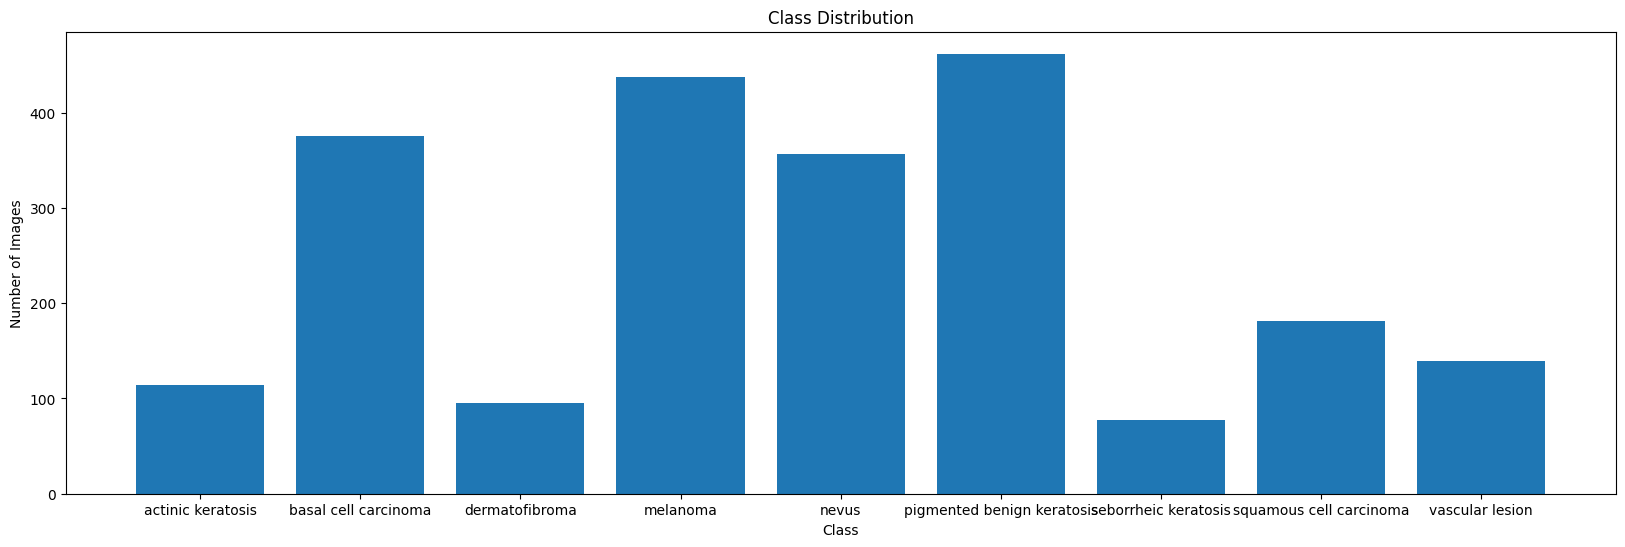

In [26]:
# Let us inspect class imbalance

class_counts = []
for i in range(NUM_CLASSES):
    # Get the filenames and class labels for the images in the current class
    class_name = reverse_class_indices[i]
    class_dir = os.path.join(train_path, class_name)
    class_count = len(os.listdir(class_dir))
    class_counts.append(class_count)
    
classes = reverse_class_indices.values()

fig = plt.figure(figsize=(20, 6))

# Create a bar chart to visualize the class distribution
plt.bar(classes, class_counts)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

In [28]:
# Let us try weightage to classes to address class imbalance
from sklearn.utils.class_weight import compute_class_weight

class_dict=train_generator.class_indices
labels= train_generator.labels

import tqdm
train_generator.reset()
X_train, y_train = next(train_generator)
for i in tqdm.tqdm(range(int(train_generator.n/batch_size)-1)): 
  img, label = next(train_generator)
  X_train = np.append(X_train, img, axis=0 )
  y_train = np.append(y_train, label, axis=0)
print(X_train.shape, y_train.shape)


# y_train is a one-hot encoded 2D array of class labels
train_classes = np.argmax(y_train, axis=1)

class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_classes),
                                        y = train_classes                                             
                                    )
print(class_weights)

# Looks like keras needs dictionary otherwise gives error
weight = {i : class_weights[i] for i in range(9)}
print(weight)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [01:24<00:00,  1.24s/it]

(2208, 180, 180, 3) (2208, 9)
[2.17109145 0.66127583 2.58245614 0.56528418 0.69107981 0.54157469
 3.22807018 1.40190476 1.80392157]
{0: 2.1710914454277286, 1: 0.6612758310871518, 2: 2.5824561403508772, 3: 0.565284178187404, 4: 0.6910798122065728, 5: 0.5415746872700515, 6: 3.2280701754385963, 7: 1.401904761904762, 8: 1.803921568627451}


In [29]:
model = create_model_base()
epochs = 20


# Train the model using the generated batches of data
step_size_train = train_generator.n // train_generator.batch_size
step_size_test = val_generator.n // val_generator.batch_size

model.fit(
        train_generator,
        steps_per_epoch=step_size_train,                                                                 
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=step_size_test,
        class_weight = weight)

model.save("ccn_model_class_weights.h5")

2023-04-18 22:00:04.749178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 1/20
69/69 [==============================] - ETA: 0s - loss: 2.1925 - accuracy: 0.1989

2023-04-18 22:01:26.579364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


69/69 [==============================] - 89s 1s/step - loss: 2.1925 - accuracy: 0.1989 - val_loss: 2.7934 - val_accuracy: 0.2083
Epoch 2/20
69/69 [==============================] - 83s 1s/step - loss: 2.0801 - accuracy: 0.1880 - val_loss: 2.5755 - val_accuracy: 0.1875
Epoch 3/20
69/69 [==============================] - 84s 1s/step - loss: 2.0473 - accuracy: 0.1817 - val_loss: 2.7669 - val_accuracy: 0.2292
Epoch 4/20
69/69 [==============================] - 85s 1s/step - loss: 1.8340 - accuracy: 0.2904 - val_loss: 2.3829 - val_accuracy: 0.2604
Epoch 5/20
69/69 [==============================] - 105s 2s/step - loss: 1.7914 - accuracy: 0.2614 - val_loss: 2.5951 - val_accuracy: 0.2812
Epoch 6/20
69/69 [==============================] - 114s 2s/step - loss: 1.7613 - accuracy: 0.2909 - val_loss: 2.2611 - val_accuracy: 0.1458
Epoch 7/20
69/69 [==============================] - 86s 1s/step - loss: 1.7543 - accuracy: 0.2927 - val_loss: 2.3978 - val_accuracy: 0.2708
Epoch 8/20
69/69 [===========

In [30]:
import Augmentor

# Define a pipeline for image augmentation
p = Augmentor.Pipeline(train_path)
p.rotate(probability=0.5, max_left_rotation=5, max_right_rotation=5)
p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
p.flip_left_right(probability=0.5)

Initialised with 2239 image(s) found.
Output directory set to /Users/dhananjayjoshi/mlai/image_exercise/data/Skin_Cancer_Images/Train/output.

In [31]:
p.sample(10000, multi_threaded=True)

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x1733DCCD0>:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 9460/10000 [31:57<00:17, 31.02 Samples/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [32]:
# Create an instance of the ImageDataGenerator class, rescaling value between 0 and 1 i.e. normalisation
augmented_datagen = ImageDataGenerator(rescale=1./255)


new_augmentation_path= train_path + "/output"

# Use the flow_from_directory method to generate batches of augmented data for training
aug_train_generator = augmented_datagen.flow_from_directory(
        new_augmentation_path,
        target_size=(180, 180), # Size of input images required
        batch_size=32,
        class_mode='categorical',
        )

Found 10000 images belonging to 9 classes.


In [34]:
# New model with  augmented data from Augmentor pipeline

NUM_CLASSES = 9
aug_model = create_model_base()

epochs = 30

checkpoint_filepath = 'ccn_checkpoint_5.h5'
checkpoint = ModelCheckpoint(checkpoint_filepath, save_weights_only=True)


# Train the model using the generated batches of data
step_size_train = aug_train_generator.n // aug_train_generator.batch_size
step_size_test = val_generator.n // val_generator.batch_size

#aug_model.load_weights('drive/My Drive/Skin_Cancer_Images/ccn_checkpoint_5.h5')

aug_model.fit(
        aug_train_generator,
        
        steps_per_epoch=step_size_train,                                                                 
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=step_size_test,
        callbacks=[checkpoint])

aug_model.save("ccn_model_6.h5")

2023-04-18 23:05:38.979893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 1/30
312/312 [==============================] - ETA: 0s - loss: 1.6072 - accuracy: 0.4273

2023-04-18 23:10:52.802385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


312/312 [==============================] - 343s 1s/step - loss: 1.6072 - accuracy: 0.4273 - val_loss: 1.8460 - val_accuracy: 0.3229
Epoch 2/30
312/312 [==============================] - 2112s 1s/step - loss: 1.2487 - accuracy: 0.5545 - val_loss: 2.4016 - val_accuracy: 0.3333
Epoch 3/30
312/312 [==============================] - 2123s 7s/step - loss: 1.0893 - accuracy: 0.6078 - val_loss: 2.6722 - val_accuracy: 0.3542
Epoch 4/30
312/312 [==============================] - 2118s 7s/step - loss: 0.9399 - accuracy: 0.6590 - val_loss: 3.7505 - val_accuracy: 0.3125
Epoch 5/30
312/312 [==============================] - 320s 1s/step - loss: 0.7733 - accuracy: 0.7248 - val_loss: 4.2455 - val_accuracy: 0.3438
Epoch 6/30
312/312 [==============================] - 2106s 7s/step - loss: 0.6810 - accuracy: 0.7563 - val_loss: 3.4878 - val_accuracy: 0.3646
Epoch 7/30
312/312 [==============================] - 2131s 7s/step - loss: 0.5355 - accuracy: 0.8086 - val_loss: 4.6948 - val_accuracy: 0.4062
Epoch

[('pigmented benign keratosis', 2058), ('melanoma', 1939), ('basal cell carcinoma', 1742), ('nevus', 1585), ('squamous cell carcinoma', 794), ('vascular lesion', 642), ('actinic keratosis', 478), ('dermatofibroma', 436), ('seborrheic keratosis', 326)]


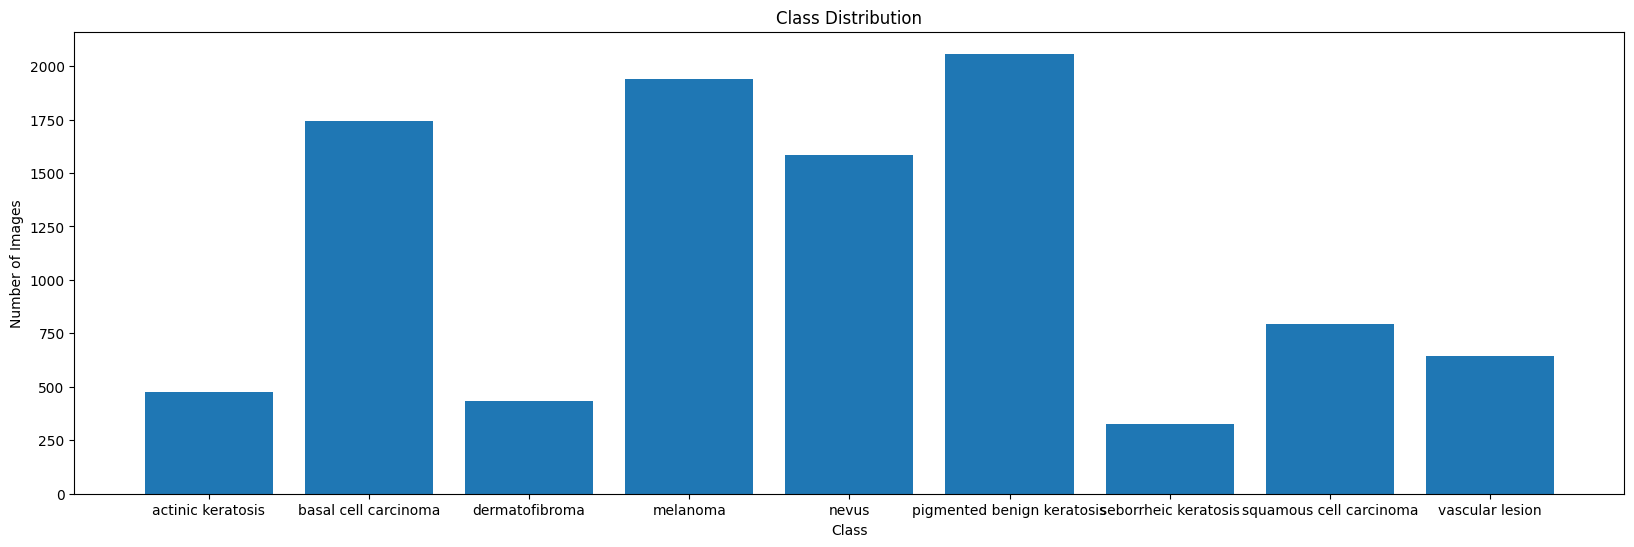

In [39]:
# Let us inspect class imbalance

new_augmentation_path= train_path + "/output"

cancer_class = {}
class_counts = []
for i in range(NUM_CLASSES):
    # Get the filenames and class labels for the images in the current class
    class_name = reverse_class_indices[i]
    class_dir = os.path.join(new_augmentation_path, class_name)
    class_count = len(os.listdir(class_dir))
    class_counts.append(class_count)
    cancer_class[class_name] = class_count
classes = reverse_class_indices.values()


sorted_cancer_classes = sorted(cancer_class.items(), key=lambda x:x[1], reverse=True)
    
print(sorted_cancer_classes)

fig = plt.figure(figsize=(20, 6))

# Create a bar chart to visualize the class distribution
plt.bar(classes, class_counts)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

In [44]:
# Let us oversample all minority classes with at least 1500 images.

minority_class_labels = ["seborrheic keratosis", "dermatofibroma", 
                         "actinic keratosis",'vascular lesion', 'squamous cell carcinoma' ]

# Define the target number of samples for each class
num_samples_per_class = 1500

new_aug_path = "image_exercise/data/Skin_Cancer_Images/Train/output"

# Loop over each class and oversample the minority class
for label in minority_class_labels:
    class_dir = new_aug_path + "/" + label
    print(class_dir)
    num_samples = len(os.listdir(class_dir))
    
    if num_samples < num_samples_per_class:
        # Calculate the number of additional samples to create
        num_augmentations = num_samples_per_class - num_samples
        
        # Define an augmentation pipeline
        p = Augmentor.Pipeline(class_dir)
        p.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=10)
        p.random_distortion(probability=0.5, grid_width=4, grid_height=4, magnitude=8)
        p.flip_left_right(probability=0.5)
        p.flip_top_bottom(probability=0.5)
        p.zoom_random(probability=0.5, percentage_area=0.9)
        
        # Generate the additional samples and save them to disk
        p.sample(num_augmentations)

/Users/dhananjayjoshi/mlai/image_exercise/data/Skin_Cancer_Images/Train/output/seborrheic keratosis
Initialised with 326 image(s) found.
Output directory set to /Users/dhananjayjoshi/mlai/image_exercise/data/Skin_Cancer_Images/Train/output/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1702F71C0>: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1174/1174 [00:21<00:00, 55.16 Samples/s]


/Users/dhananjayjoshi/mlai/image_exercise/data/Skin_Cancer_Images/Train/output/dermatofibroma
Initialised with 436 image(s) found.
Output directory set to /Users/dhananjayjoshi/mlai/image_exercise/data/Skin_Cancer_Images/Train/output/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x170A79810>: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1064/1064 [00:07<00:00, 139.60 Samples/s]


/Users/dhananjayjoshi/mlai/image_exercise/data/Skin_Cancer_Images/Train/output/actinic keratosis
Initialised with 478 image(s) found.
Output directory set to /Users/dhananjayjoshi/mlai/image_exercise/data/Skin_Cancer_Images/Train/output/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x170F91000>: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1022/1022 [00:07<00:00, 143.35 Samples/s]


/Users/dhananjayjoshi/mlai/image_exercise/data/Skin_Cancer_Images/Train/output/vascular lesion
Initialised with 642 image(s) found.
Output directory set to /Users/dhananjayjoshi/mlai/image_exercise/data/Skin_Cancer_Images/Train/output/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1702F7F10>: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 858/858 [00:05<00:00, 143.15 Samples/s]


/Users/dhananjayjoshi/mlai/image_exercise/data/Skin_Cancer_Images/Train/output/squamous cell carcinoma
Initialised with 794 image(s) found.
Output directory set to /Users/dhananjayjoshi/mlai/image_exercise/data/Skin_Cancer_Images/Train/output/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x170B155D0>: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 706/706 [00:04<00:00, 144.21 Samples/s]


[('pigmented benign keratosis', 2058), ('melanoma', 1939), ('basal cell carcinoma', 1742), ('nevus', 1585), ('actinic keratosis', 1500), ('dermatofibroma', 1500), ('seborrheic keratosis', 1500), ('squamous cell carcinoma', 1500), ('vascular lesion', 1500)]


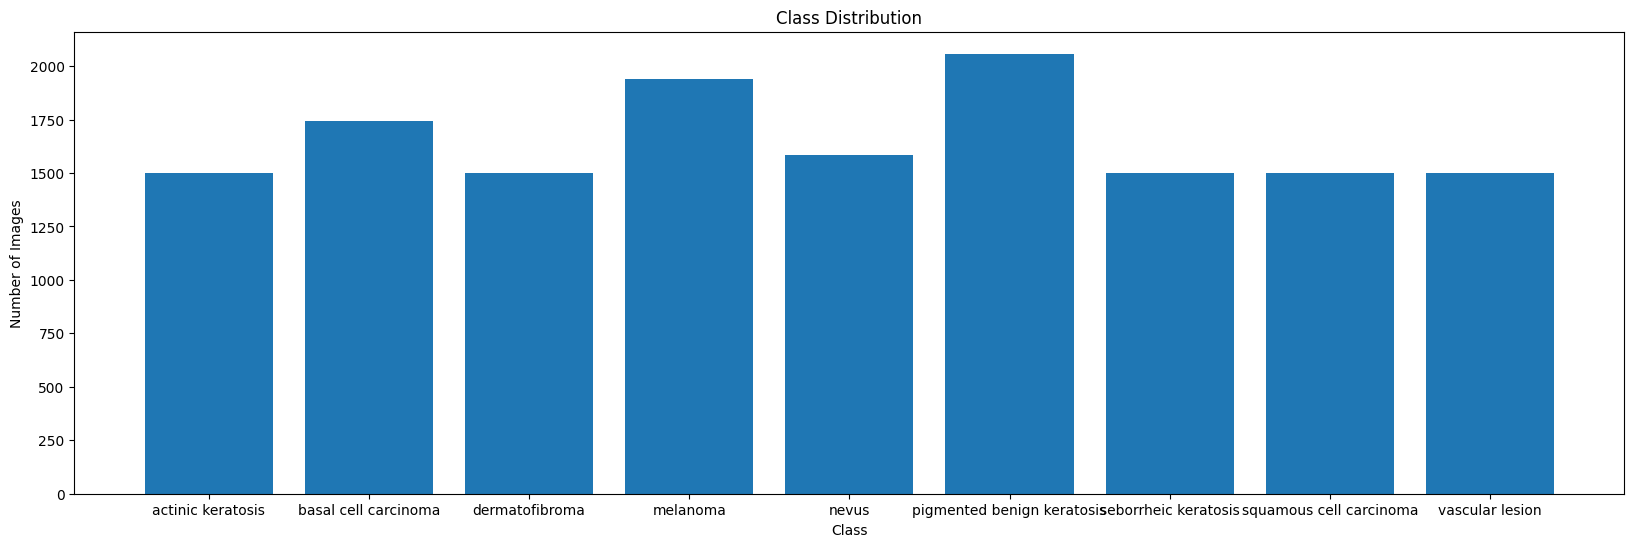

In [45]:
# Now Let us inspect class imbalance again

new_augmentation_path= train_path + "/output"

cancer_class = {}
class_counts = []
for i in range(NUM_CLASSES):
    # Get the filenames and class labels for the images in the current class
    class_name = reverse_class_indices[i]
    class_dir = os.path.join(new_augmentation_path, class_name)
    class_count = len(os.listdir(class_dir))
    class_counts.append(class_count)
    cancer_class[class_name] = class_count
classes = reverse_class_indices.values()


sorted_cancer_classes = sorted(cancer_class.items(), key=lambda x:x[1], reverse=True)
    
print(sorted_cancer_classes)

fig = plt.figure(figsize=(20, 6))

# Create a bar chart to visualize the class distribution
plt.bar(classes, class_counts)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

In [47]:
# Create an instance of the ImageDataGenerator class, rescaling value between 0 and 1 i.e. normalisation
augmented_datagen = ImageDataGenerator(rescale=1./255)


new_augmentation_path= train_path + "/output"

# Use the flow_from_directory method to generate batches of augmented data for training
aug_train_generator = augmented_datagen.flow_from_directory(
        new_augmentation_path,
        target_size=(180, 180), # Size of input images required
        batch_size=32,
        class_mode='categorical',
        )

Found 14824 images belonging to 9 classes.


In [51]:
# new model with more layers, differnt kernel size, Augmented + Balanced data
def create_model_base():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(4, 4), activation='relu', input_shape=(180, 180, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(4, 4), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(4, 4), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=256, kernel_size=(4, 4), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(units=256, activation='relu'))
    model.add(Dense(units=NUM_CLASSES, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

aug_model = create_model_base()

aug_model.fit(
        aug_train_generator,
        
        steps_per_epoch=step_size_train,                                                                 
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=step_size_test,
        callbacks=[checkpoint])

    


Epoch 1/30


2023-04-19 09:25:43.446774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


463/463 [==============================] - ETA: 0s - loss: 1.7523 - accuracy: 0.3152

2023-04-19 09:32:05.317832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


463/463 [==============================] - 389s 835ms/step - loss: 1.7523 - accuracy: 0.3152 - val_loss: 1.9848 - val_accuracy: 0.2500
Epoch 2/30
463/463 [==============================] - 388s 838ms/step - loss: 1.4478 - accuracy: 0.4407 - val_loss: 1.7297 - val_accuracy: 0.3646
Epoch 3/30
463/463 [==============================] - 375s 810ms/step - loss: 1.3542 - accuracy: 0.4811 - val_loss: 2.0017 - val_accuracy: 0.3854
Epoch 4/30
463/463 [==============================] - 368s 794ms/step - loss: 1.2469 - accuracy: 0.5172 - val_loss: 1.7939 - val_accuracy: 0.3854
Epoch 5/30
463/463 [==============================] - 362s 781ms/step - loss: 1.1736 - accuracy: 0.5531 - val_loss: 1.9972 - val_accuracy: 0.4375
Epoch 6/30
463/463 [==============================] - 366s 790ms/step - loss: 1.1037 - accuracy: 0.5788 - val_loss: 2.2532 - val_accuracy: 0.3750
Epoch 7/30
463/463 [==============================] - 407s 879ms/step - loss: 1.0086 - accuracy: 0.6174 - val_loss: 2.2348 - val_accura

In [ ]:
# Conclusion - overfitting continues to this dataset , irrepespective of oversampling, 
# augmenting , using differnt learning rate, different depths of the model.
# It will need more data and large number of epochs, lower learning rate
# to improve validation accuracy and reduce validation loss

In [55]:
# Create an instance of the ImageDataGenerator class, rescaling value between 0 and 1 i.e. normalisation
augmented_datagen = ImageDataGenerator(rescale=1./255)


new_augmentation_path= train_path + "/output"

# Use the flow_from_directory method to generate batches of augmented data for training
aug_train_generator = augmented_datagen.flow_from_directory(
        new_augmentation_path,
        target_size=(200, 150), # Size of input images required
        batch_size=32,
        color_mode='rgb', 
        class_mode='categorical',
        )

# Create an instance of the ImageDataGenerator class, rescaling value between 0 and 1 i.e. normalisation
test_datagen = ImageDataGenerator(rescale=1./255)


val_generator = test_datagen.flow_from_directory(
        test_path,
        target_size= (200, 150),
        color_mode='rgb', 
        batch_size = 32,
        class_mode = 'categorical',
        
)

# Train the model using the generated batches of data
step_size_train = aug_train_generator.n // aug_train_generator.batch_size
step_size_test = val_generator.n // val_generator.batch_size

Found 14824 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


In [64]:
# maintaining Aspect ratio and changing size of images to 200 X 150 instead of 180 X 180 as suggested
# new model with more layers, differnt kernel size, Augmented + Balanced data
def create_model_base():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(4, 4), activation='relu', input_shape=(200, 150, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(4, 4), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(4, 4), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=256, kernel_size=(4, 4), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(units=256, activation='relu'))
    model.add(Dense(units=NUM_CLASSES, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

new_model = create_model_base()
epochs = 15

new_model.fit(
        aug_train_generator,
        
        steps_per_epoch=len(aug_train_generator),                                                                 
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=len(val_generator),
        callbacks=[checkpoint])


Epoch 1/15


2023-04-19 15:24:12.196595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


464/464 [==============================] - ETA: 0s - loss: 1.7356 - accuracy: 0.3154

2023-04-19 15:30:12.210236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


464/464 [==============================] - 366s 788ms/step - loss: 1.7356 - accuracy: 0.3154 - val_loss: 2.0518 - val_accuracy: 0.2966
Epoch 2/15
464/464 [==============================] - 372s 800ms/step - loss: 1.4619 - accuracy: 0.4271 - val_loss: 2.0643 - val_accuracy: 0.3390
Epoch 3/15
464/464 [==============================] - 367s 791ms/step - loss: 1.3640 - accuracy: 0.4663 - val_loss: 1.9727 - val_accuracy: 0.3729
Epoch 4/15
464/464 [==============================] - 344s 740ms/step - loss: 1.2740 - accuracy: 0.5054 - val_loss: 1.9800 - val_accuracy: 0.4237
Epoch 5/15
464/464 [==============================] - 355s 764ms/step - loss: 1.1971 - accuracy: 0.5391 - val_loss: 2.2131 - val_accuracy: 0.4407
Epoch 6/15
464/464 [==============================] - 355s 765ms/step - loss: 1.1230 - accuracy: 0.5693 - val_loss: 2.0798 - val_accuracy: 0.4492
Epoch 7/15
464/464 [==============================] - 356s 766ms/step - loss: 1.0617 - accuracy: 0.5949 - val_loss: 2.0311 - val_accura

In [ ]:
# Conclusion - slight improvement with differnt image size mataining aspect ration. Need to be further reviewed.
